# Ensemble trends: pr + evspsbl + siconc

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })
warnings.filterwarnings('ignore')

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'evspsbl'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
#time_series_text = conf['text']
time_series_weighted_method = 'sum' #conf['weighting_method']
time_series_units = 'kg' #conf['units']
time_series_y_label = f'Evaporation ({time_series_units})'
time_series_y_range = (0, 1.5)
time_series_y_range_full = (0, 2.5)
time_series_y_range_monthly = (0, 2)
time_series_y_range_regional = (0, 4)
time_series_process = lambda x: x

In [3]:
ensemble_evspsbl, weight_evspsbl = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id,
    preprocess=conf['preprocess']
)

conf_pr = [v for v in libs.vars.variables() if v['variable_id'] == 'pr'][0]
ensemble_pr, weight_pr = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    'pr',
    preprocess=conf_pr['preprocess']
)

ensemble_siconc, weight_siconc = libs.ensemble.get_and_preprocess(
    'SImon', 
    experiment, 
    'siconc'
)

# Calculate 1980-2011 average sea ice concentration
ensemble_siconc_mask = []
for i, item in enumerate(ensemble_siconc):
    item_baseline = item['data'].sel(time=slice('1980-01-01', '2011-01-01'))
    item_baseline = item_baseline.groupby('time.month').mean('time')
    
    item_mask = dict(item)
    item_mask['data'] = item_baseline.where(item_baseline > 25)
    ensemble_siconc_mask.append(item_mask)
    

region_all = [r for r in libs.vars.nsidc_regions() if r['label'] == 'All'][0]
region_lower = [r for r in libs.vars.nsidc_regions() if r['label'] == 'Lower Latitudes'][0]
region_higher = [r for r in libs.vars.nsidc_regions() if r['label'] == 'Higher Latitudes'][0]

path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask

### Mask

In [4]:
def create_si_masked_ts(
    ensemble,
    weight,
    ensemble_siconc_mask,
    ensemble_siconc,
    nsidc_mask,
    region,
    time_series_weighted_method
):
    data_vars = {}
    
    for i, item in enumerate(ensemble):
        item_mask = [item_mask for item_mask in ensemble_siconc_mask if item_mask['label'] == item['label']]
        if len(item_mask) == 0:
            continue

        item_siconc = [item_siconc for item_siconc in ensemble_siconc if item_siconc['label'] == item['label']]
        if len(item_siconc) == 0:
            continue

        item_mask = item_mask[0]['data']
        item_siconc = item_siconc[0]['data']
        processed_data = item['data'].where(np.isin(nsidc_mask.values, region['values']))
        processed_data.attrs['color'] = item['color']
        processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
        item_mask = item_mask.drop_vars(['height', 'type'], errors='ignore')
        item_siconc = item_siconc.drop_vars(['height', 'type'], errors='ignore')

        # Mask to difference in sea ice area
        item_filtered = processed_data.where(item_siconc <= 25).groupby('time.month').where(item_mask > 25)
        item_weighted = item_filtered.weighted(weight)
        item_reduced = getattr(
            item_weighted, 
            time_series_weighted_method
        )(dim=item_weighted.weights.dims, skipna=True)

        data_vars[item['label']] = item_reduced

    ds_si = xarray.Dataset(data_vars=data_vars)
    ds_si = libs.ensemble.calc_variable_mean(ds_si)
    
    return ds_si

In [5]:
def create_masked_ts(ensemble, weight, nsidc_mask, region, time_series_weighted_method):
    data_vars = {}

    for i, item in enumerate(ensemble):
        processed_data = item['data']
        processed_data.attrs['color'] = item['color']
        processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
        item_filtered = processed_data.where(np.isin(nsidc_mask.values, region['values']))
        item_weighted = item_filtered.weighted(weight)
        item_reduced = getattr(
            item_weighted, 
            time_series_weighted_method
        )(dim=item_weighted.weights.dims, skipna=True)

        data_vars[item['label']] = item_reduced

    ds = xarray.Dataset(data_vars=data_vars)
    ds = libs.ensemble.calc_variable_mean(ds)
    
    return ds

In [6]:
si_kwargs = {
    'ensemble': ensemble_evspsbl,
    'ensemble_siconc': ensemble_siconc,
    'ensemble_siconc_mask': ensemble_siconc_mask,
    'nsidc_mask': nsidc_mask,
    'time_series_weighted_method': time_series_weighted_method,
    'weight': weight_evspsbl,
}
ds_e_si = create_si_masked_ts(region=region_all, **si_kwargs)
ds_e_si_lower = create_si_masked_ts(region=region_lower, **si_kwargs)
ds_e_si_higher = create_si_masked_ts(region=region_higher, **si_kwargs)

pr_kwargs = {
    'ensemble': ensemble_pr,
    'nsidc_mask': nsidc_mask,
    'time_series_weighted_method': time_series_weighted_method,
    'weight': weight_pr,
}
ds_pr = create_masked_ts(region=region_all, **pr_kwargs)
ds_pr_lower = create_masked_ts(region=region_lower,  **pr_kwargs)
ds_pr_higher = create_masked_ts(region=region_higher,  **pr_kwargs)

e_kwargs = {
    'ensemble': ensemble_evspsbl,
    'nsidc_mask': nsidc_mask,
    'time_series_weighted_method': time_series_weighted_method,
    'weight': weight_evspsbl,
}
ds_e = create_masked_ts(region=region_all, **e_kwargs)
ds_e_lower = create_masked_ts(region=region_lower, **e_kwargs)
ds_e_higher = create_masked_ts(region=region_higher, **e_kwargs)

## Time series

## Seasonal change

In [7]:
def plot_series(vars_series):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes = axes.flatten()
#     fig.suptitle(
#         f'''{experiment} contribution of evaporation due to sea ice decline 
#         to total evaporation (E/E₀) and precipitation (dashed; E/P) 60-90°N'''
#     )

    y_label_monthly_2 = r'$E_{S}/E$'
    y_label_monthly_3 = r'$E_{S}/P$'

    arr = []
    for i, item in enumerate(vars_series):
        var_arr = []
        for s in libs.vars.time_slices_20y():
            s_label = s['label']
            data_slice = item.sel(**s['slice']).groupby('time.month').mean('time')
            data_slice['Ensemble mean'].attrs['color'] = s['color']
            data_slice['Ensemble mean'].attrs['label'] = s['label']
            #data_slice['Ensemble mean'].attrs['plot_kwargs'] = plot_kwargs_arr[i]
            var_arr.append(data_slice)

        arr.append(var_arr)


    libs.plot.monthly_variability(
        arr[0],
        ax=axes[0],
        fig=fig,
        show_legend=False,
        variables=['Ensemble mean'],
        ylabel=y_label_monthly_2,
        yrange=(0, 1)
    );   

    libs.plot.monthly_variability(
        arr[1],
        ax=axes[1],
        fig=fig,
        show_legend=False,
        variables=['Ensemble mean'],
        ylabel=y_label_monthly_3,
        yrange=(0, 1)
    );

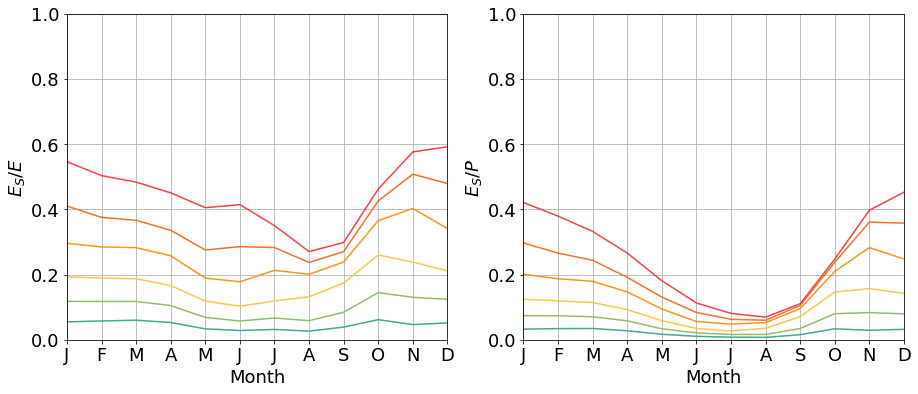

In [8]:
plot_series([
    ds_e_si / ds_e,
    ds_e_si / ds_pr
]);

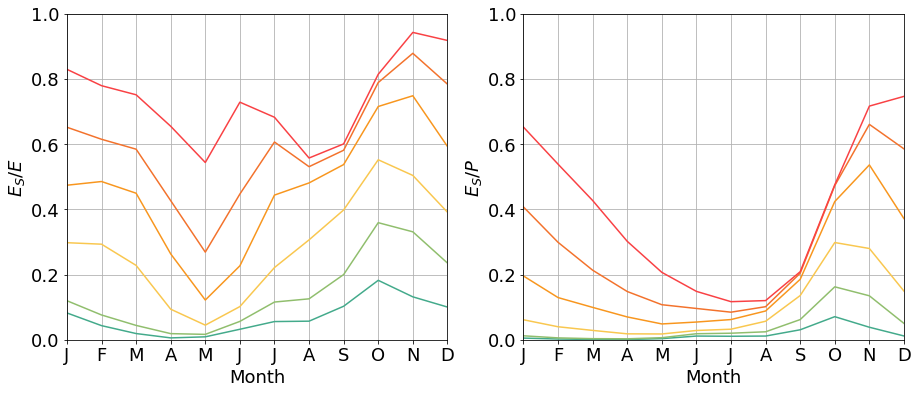

In [9]:
plot_series([
    ds_e_si_higher / ds_e_higher,
    ds_e_si_higher / ds_pr_higher
]);

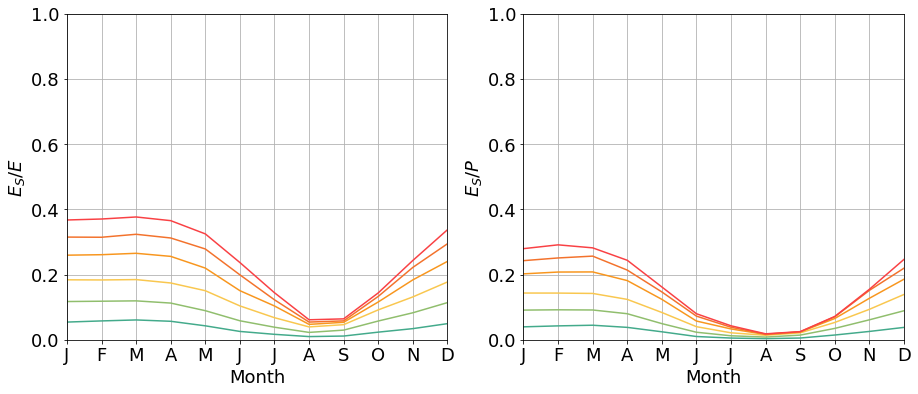

In [10]:
plot_series([
    ds_e_si_lower / ds_e_lower,
    ds_e_si_lower / ds_pr_lower
]);

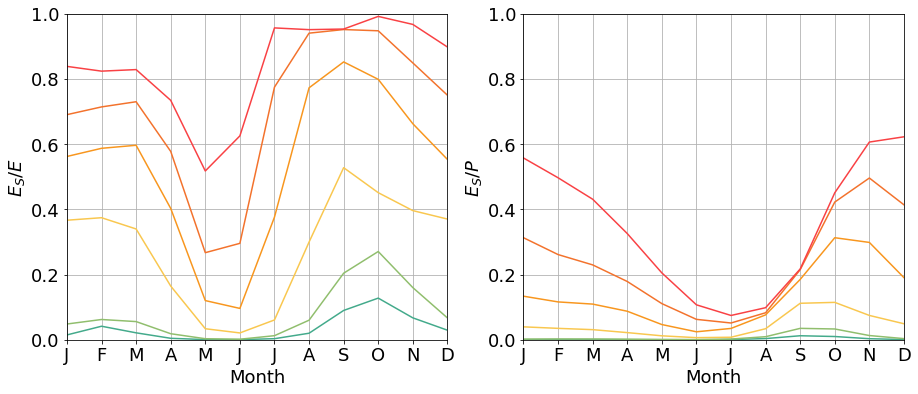

In [11]:
region_central = [r for r in libs.vars.nsidc_regions() if r['label'] == 'Central'][0]

ds_e_cen = create_masked_ts(region=region_central, **e_kwargs)
ds_pr_cen = create_masked_ts(region=region_central, **pr_kwargs)
ds_e_si_cen = create_si_masked_ts(region=region_central, **si_kwargs)

plot_series([
    ds_e_si_cen / ds_e_cen,
    ds_e_si_cen / ds_pr_cen
]);

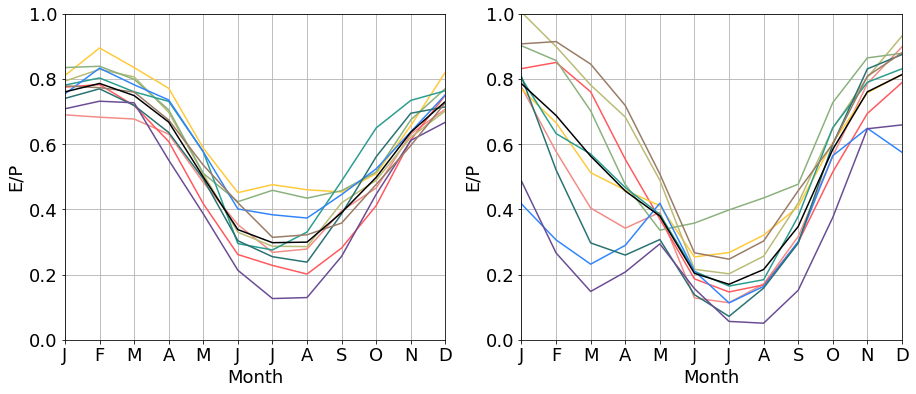

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

vars_series = [
    ds_e_lower / ds_pr_lower,
    ds_e_higher / ds_pr_higher
]

for i, item in enumerate(vars_series):
    s = libs.vars.time_slices_20y()[-1]
    s_label = s['label']
    data_slice = item.sel(**s['slice']).groupby('time.month').mean('time')

    libs.plot.monthly_variability(
        data_slice,
        ax=axes[i],
        fig=fig,
        show_legend=False,
        ylabel='E/P',
        yrange=(0, 1)
    );

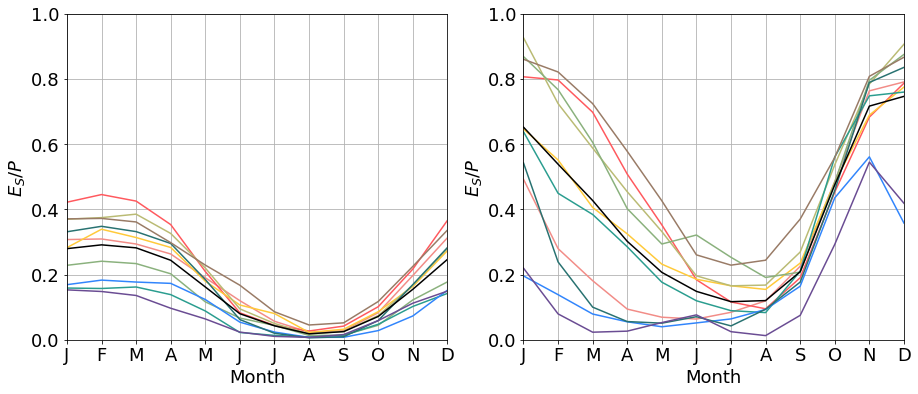

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

vars_series = [
    ds_e_si_lower / ds_pr_lower,
    ds_e_si_higher / ds_pr_higher
]

for i, item in enumerate(vars_series):
    s = libs.vars.time_slices_20y()[-1]
    s_label = s['label']
    data_slice = item.sel(**s['slice']).groupby('time.month').mean('time')

    libs.plot.monthly_variability(
        data_slice,
        ax=axes[i],
        fig=fig,
        show_legend=False,
        ylabel=r'$E_{S}/P$',
        yrange=(0, 1)
    );

In [14]:
vars_series = [
    { 'ds': ds_e_si_lower / ds_e_lower, 'key': 'e_si_lower/e_lower' },
    { 'ds': ds_e_si_lower / ds_pr_lower, 'key': 'e_si_lower/p_lower' },
    { 'ds': ds_e_si_higher / ds_e_higher, 'key': 'e_si_higher/e_higher' },
    { 'ds': ds_e_si_higher / ds_pr_higher, 'key': 'e_si_higher/p_higher' },
]

for obj in vars_series:
    print('-----', obj['key'], '-----')
    ds = obj['ds']
    
    ds = ds.groupby('time.year').mean('time')
    ds = libs.ensemble.calc_variable_mean(ds)
    
    libs.analysis.calc_diffs(ds, unit='', relative=False)    

----- e_si_lower/e_lower -----
ACCESS-CM2
-> 1980-2010: 0.07
-> 2080-2100: 0.32
-> delta: 0.25
CanESM5
-> 1980-2010: 0.08
-> 2080-2100: 0.39
-> delta: 0.30
EC-Earth3
-> 1980-2010: 0.06
-> 2080-2100: 0.25
-> delta: 0.19
HadGEM3-GC31-MM
-> 1980-2010: 0.05
-> 2080-2100: 0.31
-> delta: 0.26
IPSL-CM6A-LR
-> 1980-2010: 0.03
-> 2080-2100: 0.18
-> delta: 0.15
MIROC6
-> 1980-2010: 0.02
-> 2080-2100: 0.13
-> delta: 0.11
MPI-ESM1-2-LR
-> 1980-2010: 0.03
-> 2080-2100: 0.14
-> delta: 0.11
MRI-ESM2-0
-> 1980-2010: 0.05
-> 2080-2100: 0.27
-> delta: 0.23
NorESM2-LM
-> 1980-2010: 0.03
-> 2080-2100: 0.15
-> delta: 0.12
UKESM1-0-LL
-> 1980-2010: 0.06
-> 2080-2100: 0.36
-> delta: 0.30
Ensemble mean
-> 1980-2010: 0.05
-> 2080-2100: 0.25
-> delta: 0.20

Range 0.11053521450868385 - 0.3043435726106475
Median 0.20743939355966567
Mean 0.20249385013289953

----- e_si_lower/p_lower -----
ACCESS-CM2
-> 1980-2010: 0.04
-> 2080-2100: 0.18
-> delta: 0.14
CanESM5
-> 1980-2010: 0.05
-> 2080-2100: 0.23
-> delta: 0.18
EC